# 1. Imports and Loading the Network

The graph is loaded from the `sbb.edgelist`.
Make sure to create this edgelist through the `create_edgelist.py` script.

In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import time

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

In [3]:
print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

number of nodes: 3152
number of edges: 4678


In [4]:
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

G_lcc = G.subgraph(max_connected_comp)

Number of nodes in largest connected component: 3017


# 2. Community Detection


In [5]:
import random

def community_stats(communities, algorithm_name):
    comms_len = [len(c) for c in communities]
    print(f"{algorithm_name}: number of communities: {len(communities)}")
    print(f"{algorithm_name}: size of each community: {comms_len}")


def plot_communities(G, communities, algorithm_name):
    getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = getcolors(len(communities))

    plt.figure(figsize=(12, 9))    
    pos = nx.spring_layout(G, seed=42)     
    for i, c in enumerate(communities):
        nx.draw_networkx_nodes(     
            G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
        )            

    nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
    plt.title(f"{algorithm_name} Community Detection")
    plt.show()

## 2.1 Louvain

### 2.1.1 Louvain on the Entire Graph

In [6]:
louvain = nx.community.louvain_communities(G, seed=42)

community_stats(louvain, "Louvain")

Louvain: number of communities: 57
Louvain: size of each community: [98, 93, 131, 47, 25, 20, 26, 222, 15, 13, 117, 13, 30, 32, 12, 19, 137, 55, 83, 45, 18, 24, 99, 156, 51, 18, 20, 43, 12, 50, 3, 98, 27, 24, 74, 103, 38, 128, 20, 29, 17, 9, 202, 2, 212, 50, 50, 94, 20, 20, 79, 29, 64, 12, 7, 10, 7]


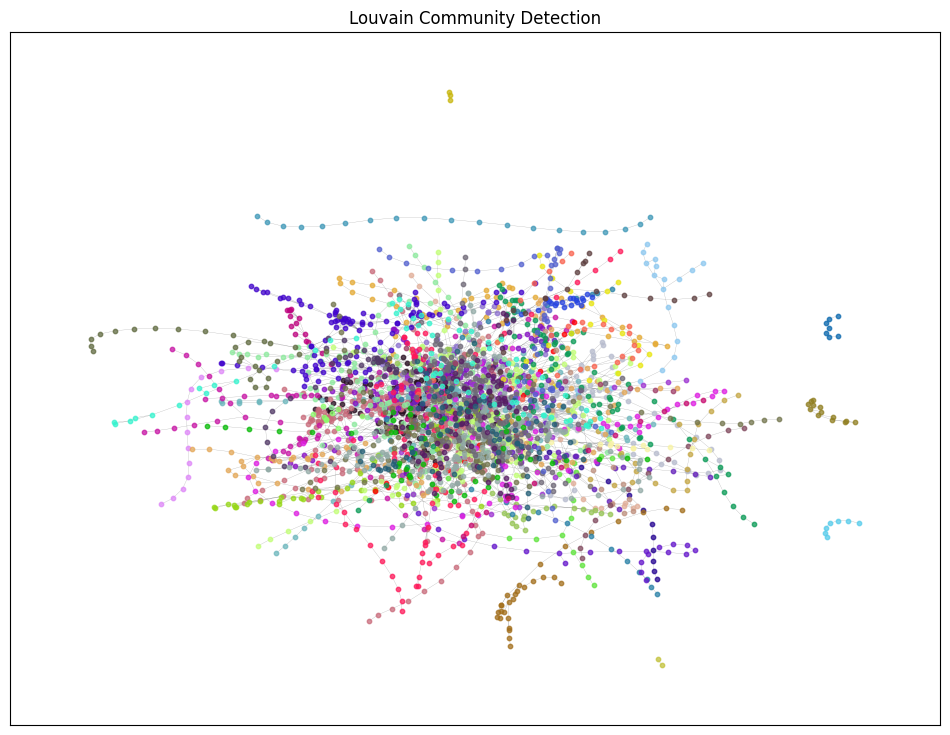

In [7]:
plot_communities(G, louvain, "Louvain")

### 2.1.2 Louvain with Largest Connected Components

In [8]:
louvain = nx.community.louvain_communities(G_lcc, seed=42)

community_stats(louvain, "Louvain LCC")       

Louvain LCC: number of communities: 45
Louvain LCC: size of each community: [93, 27, 18, 116, 116, 15, 13, 151, 79, 61, 121, 85, 134, 104, 45, 156, 135, 15, 23, 32, 51, 18, 20, 135, 43, 27, 25, 24, 19, 38, 113, 50, 72, 17, 202, 28, 43, 20, 56, 50, 29, 117, 20, 50, 211]


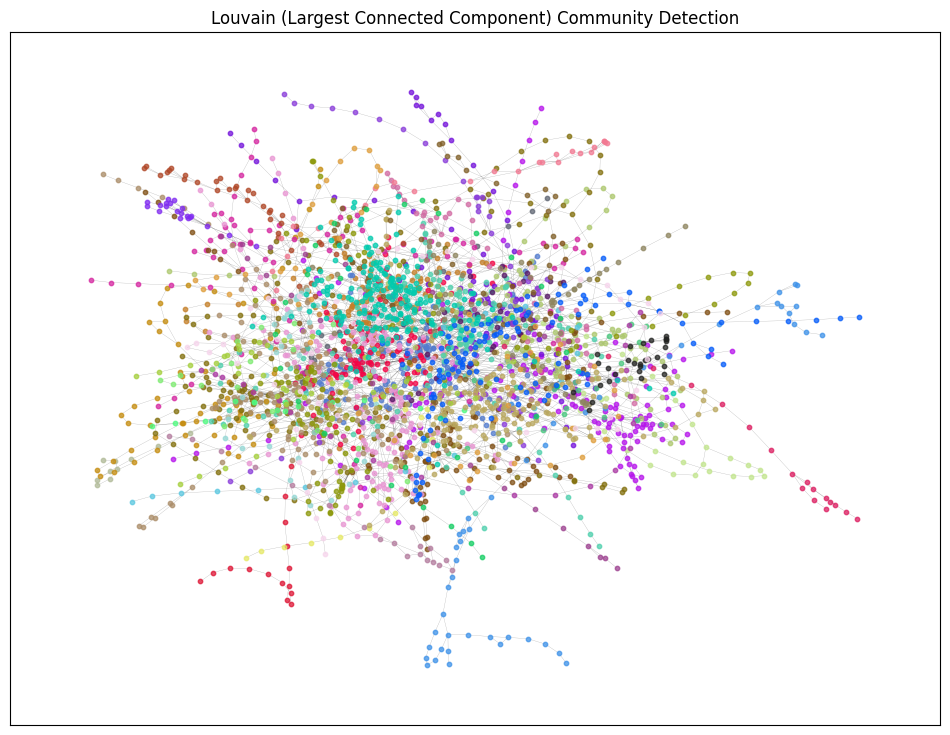

In [9]:
plot_communities(G_lcc, louvain, "Louvain (Largest Connected Component)")

### 2.1.3 Louvain: Our Implementation


In [10]:
from louvain import louvain_implementation

G_lcc = nx.Graph(G_lcc)
louvain_imp = louvain_implementation(G_lcc)

community_stats(louvain_imp, "Louvain Implementation (Largest Connected Component)")

Louvain Implementation: number of communities: 65
Louvain Implementation: size of each community: [84, 16, 7, 8, 77, 18, 114, 88, 3, 89, 13, 12, 104, 26, 9, 44, 6, 18, 46, 21, 69, 5, 10, 32, 7, 59, 40, 34, 133, 142, 21, 107, 44, 30, 21, 18, 20, 117, 23, 27, 24, 40, 25, 19, 38, 6, 16, 16, 212, 23, 4, 69, 43, 172, 3, 18, 126, 102, 50, 34, 32, 11, 98, 29, 45]


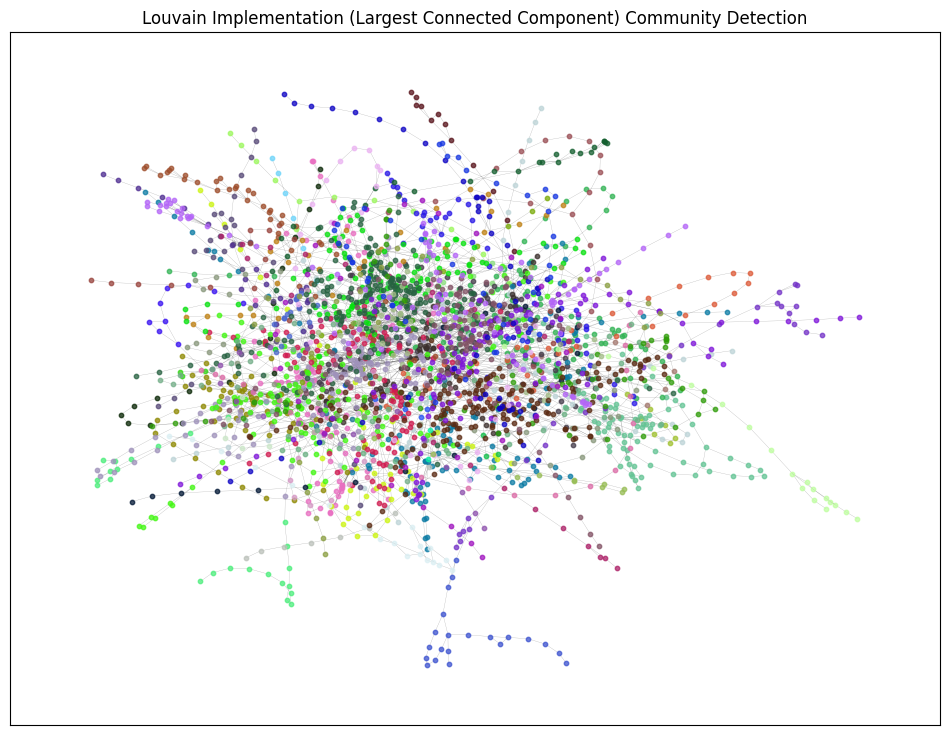

In [12]:
plot_communities(G_lcc, louvain_imp, "Louvain Implementation (Largest Connected Component)")

## 2.2 Girvan-Newman

In [ ]:
import time

def girvan_newman(G, time_threshold=1):
    gn_communities = nx.community.girvan_newman(G)

    iter_count = 0
    coms = []

    # Apply Girvan-Newman iteratively for > time_threshold hour
    timeout = time.time() + 60 * time_threshold
    while True:
        if time.time() > timeout:
            break
        
        iter_count += 1
        coms = next(gn_communities, 'end')

    print(f'number of iterations: {iter_count}')
    return coms


gn = girvan_newman(G_lcc, time_threshold=8)

In [ ]:
community_stats(gn, "Girvan Newman (Largest Connected Component)")

In [ ]:
plot_communities(G_lcc, gn, "Girvan Newman (Largest Connected Component)")

## 2.3 Leiden

In [13]:
import leidenalg as la
import igraph as ig

def leiden_communities(G):
    if isinstance(G, nx.Graph):
        graph = ig.Graph.from_networkx(G)

    partition = [set(comm) for comm in list(la.find_partition(graph, la.ModularityVertexPartition))]

    name2id = {idx: name for idx, name in enumerate(list(G.nodes))}
    comm = []
    for com in partition:
        comm.append({name2id[n] for n in com})
    return comm

In [14]:
leiden = leiden_communities(G_lcc)

community_stats(leiden, "Leiden (Largest Connected Component)")

Leiden (Largest Connected Component): number of communities: 49
Leiden (Largest Connected Component): size of each community: [191, 181, 150, 125, 118, 109, 104, 102, 99, 98, 98, 97, 94, 89, 87, 80, 67, 66, 65, 65, 64, 62, 53, 51, 50, 47, 47, 44, 44, 37, 37, 35, 32, 29, 27, 25, 25, 24, 24, 20, 20, 20, 19, 18, 17, 16, 15, 15, 15]


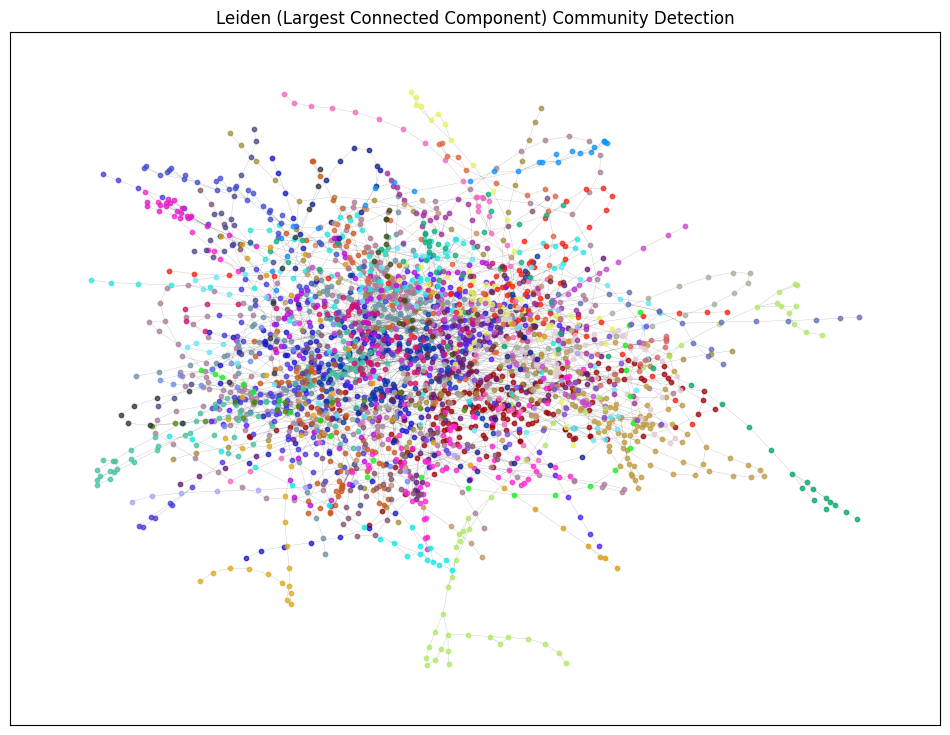

In [15]:
plot_communities(G_lcc, leiden, "Leiden (Largest Connected Component)")